# Projecting Growth of Coronavirus Cases in the U.S.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
sns.set(style='darkgrid')
%matplotlib inline

## Johns Hopkins Coronavirus Dataset

In [2]:
# Johns Hopkins COVID-19 time series datasets on GitHub
base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'
data_dir = 'csse_covid_19_data/csse_covid_19_time_series/'
source_url = base_url + data_dir

# Global Cases/Deaths/Recovered by country
cases_csv = 'time_series_covid19_confirmed_global.csv'
deaths_csv = 'time_series_covid19_deaths_global.csv'
recovered_csv = 'time_series_covid19_recovered_global.csv'

# Full URLs to datasets
cases_url = source_url + cases_csv
deaths_url = source_url + deaths_csv
recovered_url = source_url + recovered_csv

## Confirmed Cases

In [3]:
# Global Confirmed Cases
cases_global = pd.read_csv(cases_url, index_col='Country/Region').drop(
    columns=['Province/State', 'Lat', 'Long'])

# US Confirmed Cases
cases_US = cases_global.loc['US']
cases_US = pd.DataFrame(data=cases_US)
cases_US = cases_US.reset_index()
cases_US = cases_US.rename(columns={'US': 'infected', 'index':'date'})
cases_US.tail(5)

,date,infected
96,4/27/20,988197
97,4/28/20,1012582
98,4/29/20,1039909
99,4/30/20,1069424
100,5/1/20,1103461


In [4]:
# Fill in (zeros) data through Jan 21, then add US cases
ydata = [0] * 21
ydata.extend(cases_US['infected'].tolist())
xdata = np.arange(len(ydata))

# Get the day of the year for today
today = len(ydata) - 1

# Get the date for the most recent entry
latest = cases_US.loc[len(cases_US)-1,'date']

## Curve Fitting

In [5]:
# Number of Cases (Gompertz model)
# https://elm.nsupdate.info/maths.html
# https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0178691&type=printable
def N(x, d, T2, Nmax):
    return Nmax * np.exp( -np.exp( -np.log(2) / T2 * (x-d) ) )

In [6]:
# Advanced Gompertz Function
# https://elm.nsupdate.info/covid-19/maths/
# NOTE: this is currently not working...

# def N(x, d, T2, Nmax, w):
#     return Nmax * np.exp(-(np.exp( -(np.log(2**(1/w))) / (T2 * w**(1/w))**w * (x**w - d**w) )))

In [7]:
# SciPy curve fit, today
popt, pcov = curve_fit(N, xdata, ydata, maxfev=100000)

print("d={:4.3f}, T2={:4.3f}, Nmax={:4.3e}".format(*tuple(popt)))

d=101.889, T2=11.481, Nmax=1.476e+06


In [8]:
# Previous prediction
# Let's also look at n number of days ago to see how well the predictions match up
n = 7
ydata_prev = ydata[:-n]
xdata_prev = np.arange(len(ydata_prev))

In [9]:
# SciPy curve fit, n days ago
popt_prev, pcov_prev = curve_fit(N, xdata_prev, ydata_prev, maxfev=10000)

print("d={:4.3f}, T2={:4.3f}, Nmax={:4.3e}".format(*tuple(popt_prev)))

d=99.388, T2=10.059, Nmax=1.277e+06


## Projected COVID Cases, USA

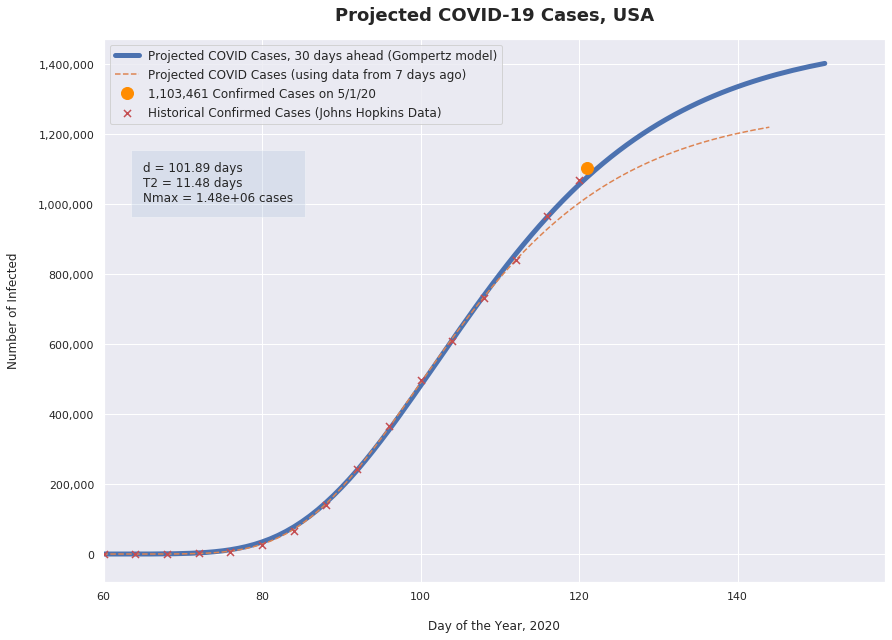

In [10]:
# Set up the figure
f = plt.figure(figsize=(14,10))
plt.xlabel('Day of the Year, 2020', labelpad=18)
plt.ylabel('Number of Infected', labelpad=18)
plt.title("Projected COVID-19 Cases, USA", fontsize=18, pad=18, fontweight='bold')

# Plot the Gompertz fit for previous cases, plus project 'D' days ahead
D = 30
days = np.arange(len(xdata) + D)
plt.plot(days, N(days, *popt), '-', lw=5, zorder=5,
    label='Projected COVID Cases, {} days ahead (Gompertz model)'.format(D))

# Plot the Gompertz fit with data from n days ago
days_prev = np.arange(len(xdata_prev) + D)
plt.plot(days_prev, N(days_prev, *popt_prev), '--', zorder=10,
    label='Projected COVID Cases (using data from {} days ago)'.format(n))

# Scatterplot every 4th day of confirmed cases
skip = 4
x, y = xdata[::skip], ydata[::skip]
plt.scatter(x, y, marker='x', color='r', s=50, zorder=20,
    label='Historical Confirmed Cases (Johns Hopkins Data)')

# Plot a point representing today's total cases
plt.plot(today, ydata[today], "o", color='darkorange', ms=12, zorder=30,
    label='{:,} Confirmed Cases on {}'.format(ydata[today], latest))

# Format y-axis labels with thousands separator
ax = plt.gca()
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Set x-axis limits, start on March 1 (Day 61)
# (no need to see all the zeros in January)
ax.set_xlim(60)

# Text box 
ax.text(0.05, 0.7, 'd = {:4.2f} days \nT2 = {:4.2f} days \nNmax = {:4.2e} cases'.format(*tuple(popt)),
    bbox={'facecolor': 'lightsteelblue', 'alpha': 0.3, 'pad': 12},
        fontsize=12, transform=ax.transAxes)

# Show the figure with legend
ax.legend(loc='upper left', fontsize=12)
plt.show()

# Save the figure as PNG
f.savefig("charts/covid-{}.png".format(latest.replace('/','.')), dpi=200)

## Forecasting

In [11]:
# Estimate number of cases 'f' days from now
f = 14
future = today + f
print(f"In {f} days, there will be {int(np.around(N(future, *popt),0)):,} confirmed cases in the US.")

In 14 days, there will be 1,289,061 confirmed cases in the US.


In [12]:
# Update the README.md file with the new chart
file = open("README.md", "w")

file.write(
"""# Introduction

This Jupyter notebook uses the [Johns Hopkins Coronavirus dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/README.md) to project and predict COVID case growth in the United States over the next 30 days.

You can run this notebook yourself using Binder:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/bws428/covid-19/master?filepath=covid-projections.ipynb)

![Projected Cases plot](https://raw.githubusercontent.com/bws428/covid-19/master/charts/covid-{}.png)"""
    .format(latest.replace('/','.')))
           
file.close()